In [1]:
import tensorflow as tf

from keras import backend as K

from keras.preprocessing.image import load_img
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

from tensorflow.python.keras import optimizers
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import predict_signature_def
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

from math import sqrt
from math import pi
from math import exp

from matplotlib import pyplot as plt

from PIL import Image

from json_tricks import dump, dumps

import matplotlib.image as mpimg
import numpy as np
import pandas as pd

import cv2
import base64

import os

Using TensorFlow backend.


In [2]:
# Fixed for our Hot Dog & Pizza classes
NUM_CLASSES = 2

# Classification type
CLASSIFICATION_TYPE = 'binary'

# Fixed for Hot Dog & Pizza color images
CHANNELS = 3

# AlexNet specific input image size
IMAGE_RESIZE = 227

# Padding strategy to keep the same image size
SAME_PADDING = 'same'

# Padding strategy with right and bottom crop
VALID_PADDING = 'valid'

# Pooling strategy
RESNET50_POOLING_AVERAGE = 'avg'

# Activation functions
CONVOLUTIONAL_LAYER_ACTIVATION = 'relu'
DENSE_LAYER_ACTIVATION = 'sigmoid'

# Used to evaluate the error
OBJECTIVE_FUNCTION = 'binary_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 5
EARLY_STOP_PATIENCE = 5

# Batch sizes for training and validation
BATCH_SIZE_TRAINING = 128
BATCH_SIZE_VALIDATION = 64

# Generate images
GENERATION_RATIO = 1
TOTAL_TRAIN_IMAGES = 6400

TOTAL_TEST_IMAGES = 1250

SCALE = 300

# Steps for each epoch
STEPS_PER_EPOCH_TRAINING = TOTAL_TRAIN_IMAGES / BATCH_SIZE_TRAINING
STEPS_PER_EPOCH_VALIDATION = TOTAL_TEST_IMAGES / BATCH_SIZE_VALIDATION

# Using 1 to easily manage mapping between test_generator & prediction
BATCH_SIZE_TESTING = 1

# Work directory to save the checkpoints
WORK_FOLDER = 'working'

# Processed images folder name
PROCESSED_FOLDER = "processed"

# Checkpoint file name
CHECKPOINT_FILE = 'best.hdf5'

# Automatic save and replace mode of the weights
MODEL_CHECKPOINT_MODE = 'auto'

# The metrics that we want to monitor
LOSS_MONITOR = 'val_loss'

# Weights file name
WEIGHTS_FILE = 'best_weights.h5'

# The name of the .h5 file containing the pretrained weights for the ResNet50
WEIGHTS_FILE = 'resnet50_weights_notop.h5'

In [3]:
# Base folder path for the Hot Dog & Pizza classification images
BASE_FOLDER_PATH = os.path.join('datasets', 'kaggle')

# The path to the training images
TRAIN_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'train')

# The path to the validation images
VALIDATION_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'valid')

# The path to the test images
TEST_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'test')

# Checkpoint file path
CHECKPOINT_FILE_PATH = os.path.join(WORK_FOLDER, CHECKPOINT_FILE)

# Weights file path
WEIGHTS_FILE_PATH = os.path.join(WORK_FOLDER, WEIGHTS_FILE)

# The folder path where we will save the final trained model
MODEL_EXPORT_PATH = os.path.join(WORK_FOLDER, "saved_model")

LABELS_FILE_PATH = os.path.join(BASE_FOLDER_PATH, "trainLabels.csv")

In [4]:
def create_image_paths(image_path):
    image_names = os.listdir(image_path)
    image_paths = [os.path.join(image_path, image_name) for image_name in image_names]
    return image_paths

In [5]:
read = lambda image_name: np.asarray(load_img(image_name, 'uint8'))

def read_images(image_path):
    image_paths = create_image_paths(image_path)
    images = np.array([read(image_path) for image_path in image_paths])
    return images

In [6]:
read_scale = lambda image_name: np.asarray(load_img(image_name, target_size=(IMAGE_RESIZE, IMAGE_RESIZE)))
    
def read_scaled_images(image_path):
    image_paths = create_image_paths(image_path)
    images = np.array([read_scale(image_path) for image_path in image_paths], dtype='uint8')
    return images

In [7]:
def scaleRadius(img, scale):
    x = img[int(img.shape[0]/2), :, :].sum(1)
    r = (x>x.mean()/10).sum()/2
    s = scale * 1.0 / r
    return cv2.resize(img, (0, 0), fx = s, fy = s)

In [8]:
def process_image(img_path, target_path, scale):
    img = cv2.imread(img_path)
    
    img = scaleRadius(img, scale)
    
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0 , 0), scale/30) , -4 ,128)
    
    overlay = np.zeros(img.shape)
    
    cv2.circle(overlay, (int(img.shape[1]/2), int(img.shape[0]/2)), int(scale * 0.9), (1, 1, 1), -1, 8, 0)
    
    img = img * overlay + 128 * (1 - overlay)
    
    cv2.imwrite(target_path, img)

In [9]:
def process_images(images, source_path, target_path, verbose=False):
    for image in images:
        try:
            process_image(os.path.join(source_path, image),
                          os.path.join(target_path, image),
                          SCALE)
            if(verbose):
                print("SUCCESS " + image)
        except:
            if(verbose):
                print("FAIL " + image)

In [10]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [11]:
def to_savedmodel(model, export_path):
    #Convert the Keras HDF5 model into TensorFlow SavedModel.
    K.get_session().run(tf.global_variables_initializer())

    builder = saved_model_builder.SavedModelBuilder(export_path)

    signature = predict_signature_def(
      inputs={'input': model.inputs[0]}, outputs={'income': model.outputs[0]})

    with K.get_session() as sess:
        builder.add_meta_graph_and_variables(
            sess=sess,
            tags=[tag_constants.SERVING],
            signature_def_map={
                signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature
            })
        builder.save()

In [12]:
def predict_class(model, image):
    scaled_image = image/255.
    y_pred = model.predict_classes([[scaled_image]])
    confidence = model.predict([[scaled_image]])
    print("Predicted class:")

    if y_pred[0][0] == 1:
        print("Yes")
    else:
        print("No")

    print(y_pred[0][0])

    print("Confidence:")
    print(confidence[0][0])

In [13]:
read = lambda image_name: np.asarray(load_img(image_name, target_size=(IMAGE_RESIZE, IMAGE_RESIZE)))
    
def read_images(image_path):
    image_names = os.listdir(image_path)
    image_paths = [os.path.join(image_path, image_name) for image_name in image_names]
    images = np.array([read(image_path) for image_path in image_paths], dtype='uint8')
    return images

In [15]:
train_images = os.listdir(TRAIN_FOLDER_PATH)

In [16]:
os.path.join(TRAIN_FOLDER_PATH, train_images[0])

'datasets\\kaggle\\train\\4190_left.jpeg'

In [17]:
img = cv2.imread(os.path.join(TRAIN_FOLDER_PATH, train_images[0]))

In [21]:
process_images(train_images, TRAIN_FOLDER_PATH, os.path.join(TRAIN_FOLDER_PATH, PROCESSED_FOLDER))

In [89]:
test_images = os.listdir(TEST_FOLDER_PATH)

In [90]:
process_images(test_images, TEST_FOLDER_PATH, os.path.join(TEST_FOLDER_PATH, PROCESSED_FOLDER))

In [14]:
validation_images = os.listdir(VALIDATION_FOLDER_PATH)

In [15]:
process_images(validation_images, VALIDATION_FOLDER_PATH, os.path.join(VALIDATION_FOLDER_PATH, PROCESSED_FOLDER))

In [14]:
df = pd.read_csv(LABELS_FILE_PATH)

In [15]:
class_names = {0: "NO", 1: "YES", 2: "YES", 3: "YES", 4: "YES"}

In [16]:
binary_value = {"NO": 0, "YES": 1}

In [17]:
df.level.replace(to_replace=class_names, inplace=True)

In [18]:
df.level.replace(to_replace=binary_value, inplace=True)

In [19]:
df.pivot_table(index='level', aggfunc=len)

,image
level,
0,25810
1,9316


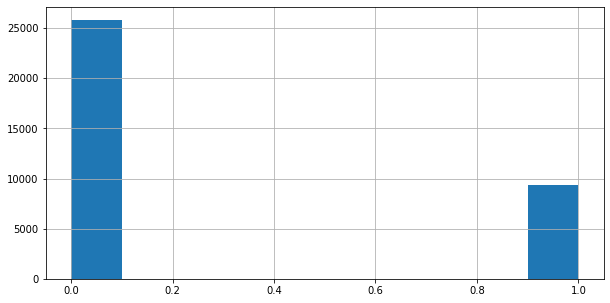

In [21]:
df['level'].hist(figsize = (10, 5))

In [22]:
df['path'] = df['image'].map(lambda x: os.path.join(os.path.join(TRAIN_FOLDER_PATH, "processed"), '{}.jpeg'.format(x)))

In [23]:
df['exists'] = df['path'].map(os.path.exists)

In [24]:
df['exists'].value_counts()

False    34776
True       350
Name: exists, dtype: int64

In [25]:
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe

In [26]:
df['path'] = df['path'].map(lambda x: x.split("\\")[-1])

In [27]:
df

,level,path
0,0,4548_left.jpeg
1,0,4223_right.jpeg
2,0,4253_left.jpeg
3,1,54_right.jpeg
4,1,4252_right.jpeg
...,...,...
345,1,54_left.jpeg
346,0,60_right.jpeg
347,1,4545_right.jpeg
348,1,4196_left.jpeg


In [28]:
train_df, val_df = train_test_split(df,test_size=0.2)

In [29]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,200
1,80


New Data Size: 400 Old Size: 280


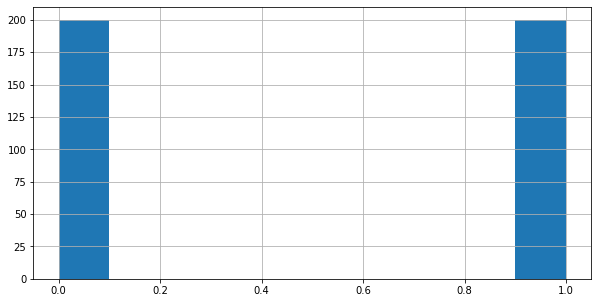

In [30]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df)

In [31]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,200
1,200


In [32]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

470

In [33]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = WEIGHTS_FILE))

model.add(Dense(1, activation = DENSE_LAYER_ACTIVATION))

model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [35]:
sgd = optimizers.SGD(lr = 0.002, decay = 1e-6, momentum = 0.9, nesterov = True)

In [36]:
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [37]:
cb_early_stopper = EarlyStopping(monitor = LOSS_MONITOR, patience = EARLY_STOP_PATIENCE)

cb_checkpointer = ModelCheckpoint(filepath = CHECKPOINT_FILE_PATH, monitor = LOSS_MONITOR, save_best_only = True, mode = MODEL_CHECKPOINT_MODE)

learning_rate_reduction = ReduceLROnPlateau(monitor=LOSS_MONITOR, 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [38]:
class_names = {0: "NO", 1: "YES"}

In [39]:
df.level.replace(to_replace=class_names, inplace=True)

In [40]:
df["level"]

0       NO
1       NO
2      YES
3       NO
4       NO
      ... 
320     NO
113     NO
193    YES
90     YES
237     NO
Name: level, Length: 470, dtype: object

In [41]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [42]:
train_generator=datagen.flow_from_dataframe(
    dataframe=df,
    directory=os.path.join(TRAIN_FOLDER_PATH, PROCESSED_FOLDER),
    x_col="path",
    y_col="level",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode=CLASSIFICATION_TYPE,
    target_size=(224,224))

Found 353 validated image filenames belonging to 2 classes.


In [43]:
valid_generator=datagen.flow_from_dataframe(
    dataframe=df,
    directory=os.path.join(TRAIN_FOLDER_PATH, PROCESSED_FOLDER),
    x_col="path",
    y_col="level",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode=CLASSIFICATION_TYPE,
    target_size=(224,224))

Found 117 validated image filenames belonging to 2 classes.


In [44]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [45]:
STEP_SIZE_TRAIN

11

In [46]:
STEP_SIZE_VALID

3

In [47]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [48]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[cb_checkpointer, learning_rate_reduction, cb_early_stopper],
                    epochs=NUM_EPOCHS
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
12/12 [==============================] - 107s 9s/step - loss: 0.7578 - acc: 0.4873 - val_loss: 0.6873 - val_acc: 0.5897
Epoch 2/5
12/12 [==============================] - 87s 7s/step - loss: 0.6909 - acc: 0.5552 - val_loss: 0.6913 - val_acc: 0.5556
Epoch 3/5
4/4 [==============================] - 23s 6s/step - loss: 0.6923 - acc: 0.5556

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
12/12 [==============================] - 92s 8s/step - loss: 0.6274 - acc: 0.6261 - val_loss: 0.6923 - val_acc: 0.5556
Epoch 4/5
12/12 [==============================] - 92s 8s/step - loss: 0.5752 - acc: 0.7195 - val_loss: 0.6852 - val_acc: 0.5556
Epoch 5/5
12/12 [==============================] - 98s 8s/step - loss: 0.5530 - acc: 0.7535 - val_loss: 0.7636 - val_acc: 0.4530


In [49]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

sess = tf.Session()
graph = tf.get_default_graph()

# IMPORTANT: models have to be loaded AFTER SETTING THE SESSION for keras!
# Otherwise, their weights will be unavailable in the threads after the session there has been set
set_session(sess)

In [50]:
loaded_model = load_model(CHECKPOINT_FILE_PATH)

In [51]:
to_savedmodel(loaded_model, MODEL_EXPORT_PATH)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: working\saved_model\saved_model.pb


In [52]:
test_folder_path = os.path.join(TEST_FOLDER_PATH, PROCESSED_FOLDER)

In [53]:
test_images = read_images(test_folder_path)

In [82]:
index = 10

In [83]:
len(test_images)

40

In [84]:
image_names = os.listdir(test_folder_path)

In [85]:
image_names[index]

'49_left.jpeg'

In [86]:
test_images[index].shape

(227, 227, 3)

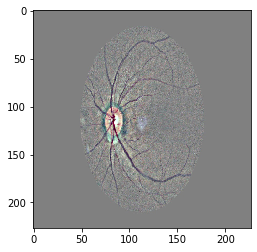

In [87]:
plt.imshow(test_images[index])

In [88]:
predict_class(loaded_model, test_images[index])

Predicted class:
No
0
Confidence:
0.29404
